In [112]:
import numpy as np
import pandas as pd

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae

pd.plotting.register_matplotlib_converters()

import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
path = "https://github.com/dataworkshop/5dwchallenge_2019/blob/master/challenge5/input/visits.csv?raw=true"

df = pd.read_csv(path, parse_dates=['published'], index_col='published')
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
post_id    134137 non-null int64
dtypes: int64(1)
memory usage: 2.0 MB


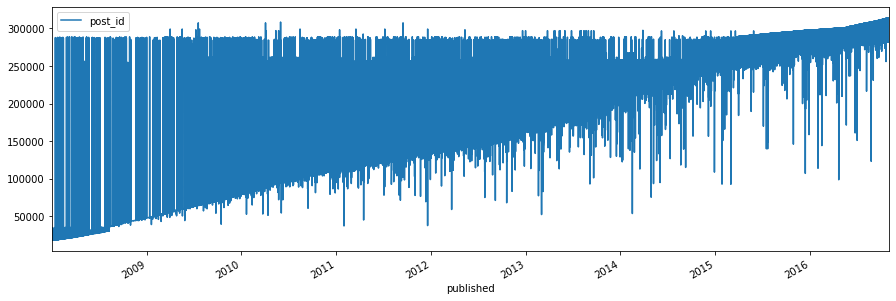

In [115]:
df.plot(figsize=(15,5));

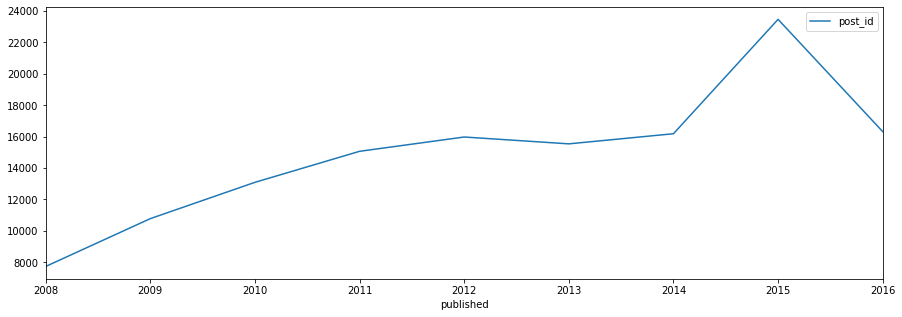

In [116]:
df.resample('1y').count().plot(figsize=(15,5));

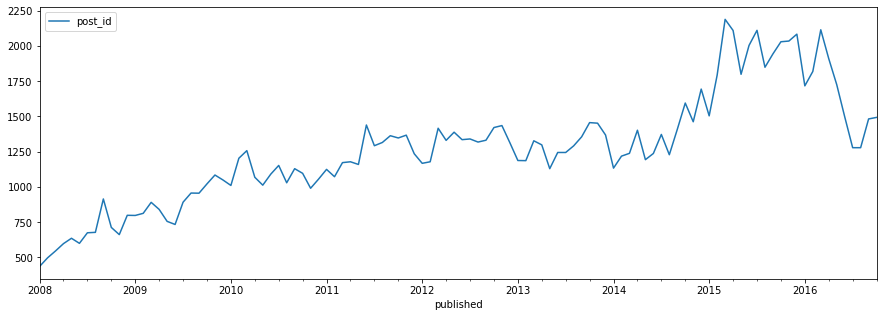

In [117]:
df.resample('1m').count().plot(figsize=(15,5));

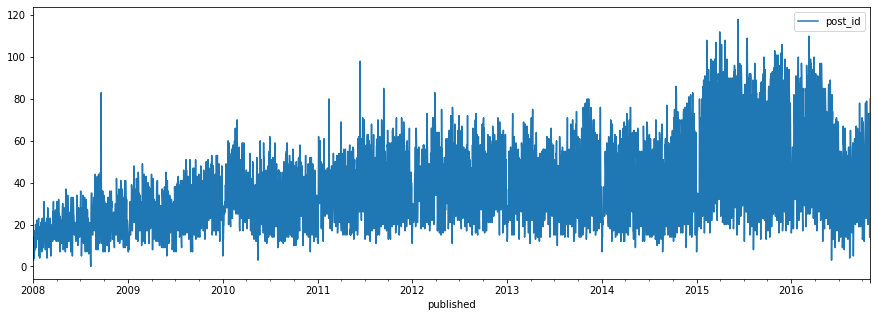

In [118]:
df.resample('1d').count().plot(figsize=(15,5));

In [119]:
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [120]:
df_day = df.resample('1d').count().reset_index()
df_day.columns = ['ds', 'y']


df_day.head()

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4


In [121]:
num_points_to_pred = 100
train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]

train_log = train.copy()
train_log['y'] = np.log1p(train_log['y'])

In [122]:
m = Prophet()
m.fit(train_log)
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=False)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [123]:
future.head()

,ds
0,2016-07-24
1,2016-07-25
2,2016-07-26
3,2016-07-27
4,2016-07-28


In [124]:
forecast = m.predict(future)
forecast['yhat'] = np.expm1(forecast.yhat)

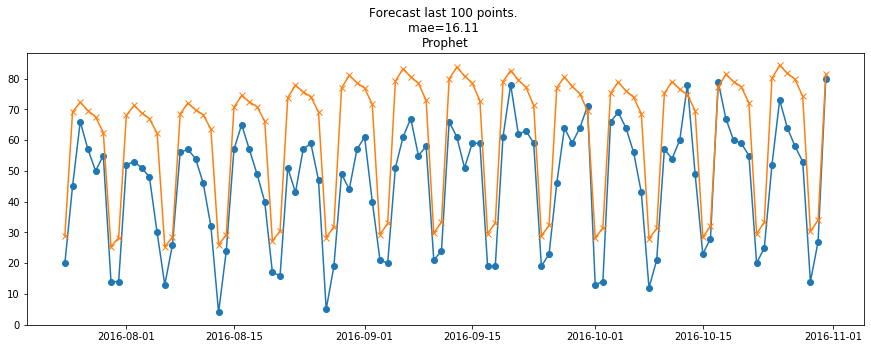

In [125]:
plot_forecast(test, forecast)

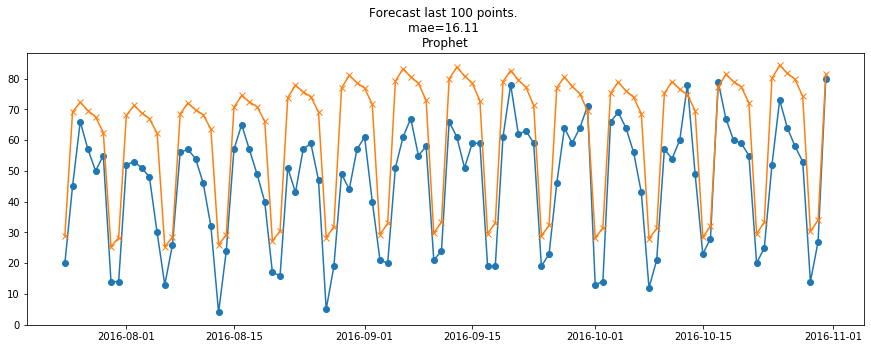

In [126]:
def plot_forecast(test,forecast):
    forecast = forecast[-num_points_to_pred:]
    score = np.round(mae(test.y, forecast.yhat),2)
    
    plt.figure(figsize=(15,5))
    plt.title('Forecast last {} points. \nmae={} \nProphet'.format(num_points_to_pred,score))
    plt.plot(test.ds, test.y, 'o-', label='truth')
    plt.plot(test.ds, forecast.yhat, 'x-', label='Forecast')
    plt.legend;
    
plot_forecast(test, forecast)

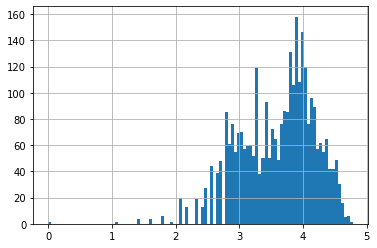

In [107]:
np.log1p(train.y).hist(bins=num_points_to_pred);

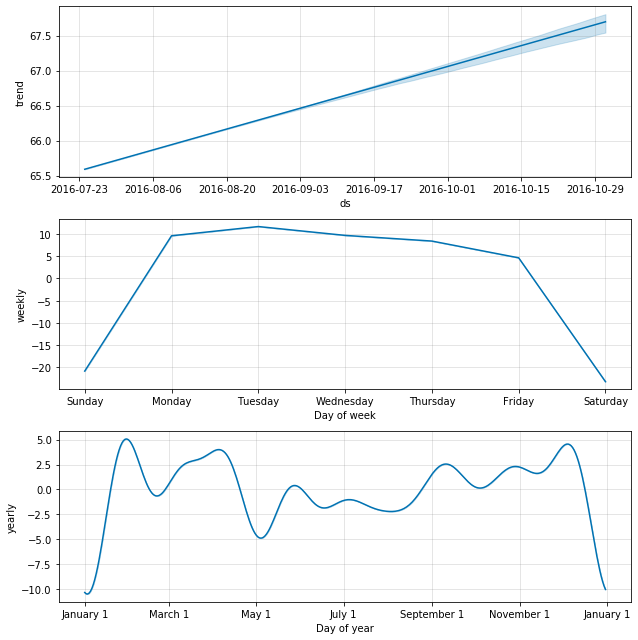

In [108]:
m.plot_components(forecast);

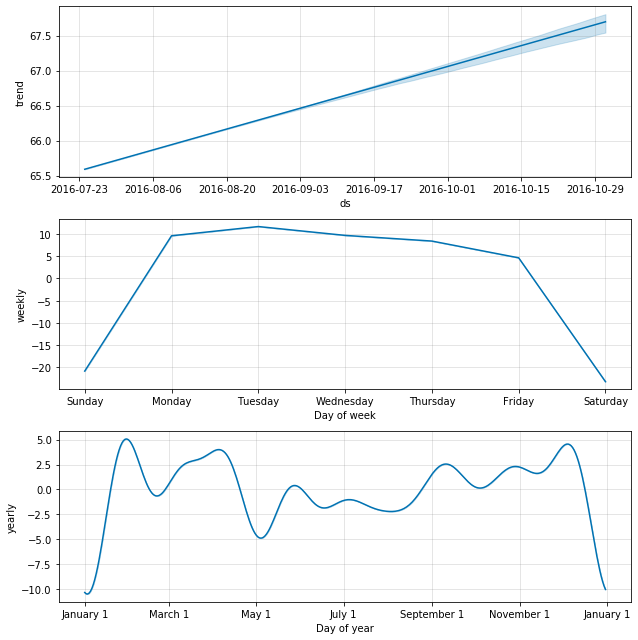

In [109]:
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)
m.plot_components(forecast);


In [127]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [128]:


df_cv = cross_validation(m,initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 60 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-06-23 00:00:00


In [129]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-11-12,3.944508,3.593495,4.316329,4.330733,2014-11-11
1,2014-11-13,3.915899,3.552524,4.254252,4.290459,2014-11-11
2,2014-11-14,3.853387,3.520352,4.207094,4.110874,2014-11-11
3,2014-11-15,3.050778,2.713565,3.400620,3.044522,2014-11-11
4,2014-11-16,3.104367,2.745832,3.431159,3.295837,2014-11-11


In [130]:
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,coverage
0,3 days,0.122749,0.350356,0.244869,0.073326,0.772222
1,4 days,0.079281,0.281569,0.223428,0.060013,0.811111
2,5 days,0.086096,0.293420,0.231216,0.062990,0.794444
3,6 days,0.092292,0.303797,0.234825,0.063763,0.788889
4,7 days,0.103704,0.322031,0.249513,0.067839,0.761111


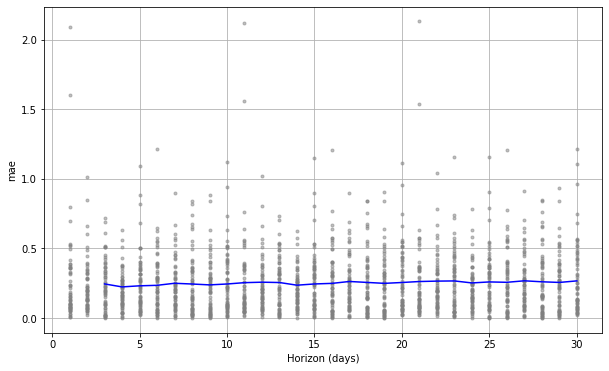

In [131]:
plot_cross_validation_metric(df_cv, 'mae');

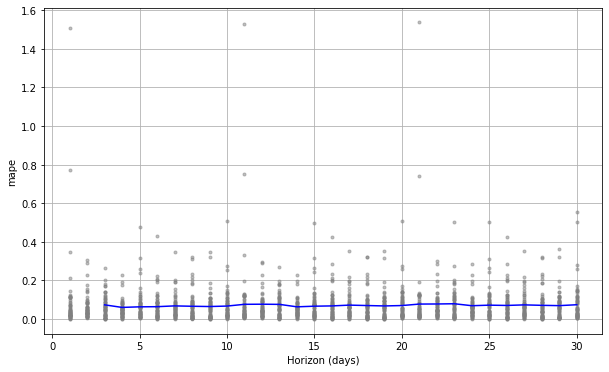

In [132]:
plot_cross_validation_metric(df_cv, 'mape');